# Document Clustering with Python (Week 6)

This lab is prepared with the tutorial "Document Clustering with Python" on http://brandonrose.org/clustering.

This lab will explain how to cluster a set of documents to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the example. This lab covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/)
<li> conducting a hierarchical clustering on the corpus
<li> plotting complete and average dendrograms
<li> conducting an EM clustering on the corpus
</ul>

But first, Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
!pip install mpld3
import mpld3
%matplotlib inline

     |████████████████████████████████| 798kB 3.8MB/s eta 0:00:01
  Stored in directory: /Users/robin/Library/Caches/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


# Stopwords, stemming, and tokenizing

In [2]:
# import lists: titles, links, genres, wikipedia, and imdb synopses
titles = open('title_list.txt').read().split('\n')
# ensures that only the first 100 are read in
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

### load wiki synopses
synopses_wiki = open('synopses_list_wiki.txt', encoding='utf-8').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki

### load imdb synopses
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb
    
print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(genres)) + ' genres')
print(str(len(synopses_wiki)) + ' wiki synopses')
print(str(len(synopses_imdb)) + ' imdb synopses')


100 titles
100 links
100 genres
100 wiki synopses
100 imdb synopses


In [3]:
# combine synopses from wiki and imdb

synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i] 
    synopses.append(item)

In [4]:
# generates index for each item in the corpora (in this case it's just rank) 
# and we will use this for scoring later

ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

In [5]:
print(titles[:10]) # first 10 titles

['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca', "One Flew Over the Cuckoo's Nest", 'Gone with the Wind', 'Citizen Kane', 'The Wizard of Oz', 'Titanic']


In [6]:
print(synopses[0][:200]) # first 200 characters in first synopsis (The Godfather)

 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son,


This section is focused on defining some functions to manipulate the synopses. First, load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. 

In [7]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [8]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below we define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens)) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

We use both these functions to create a dictionary which becomes important in case we want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. 


In [9]:
# here we define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below we use stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [10]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed) # add the allwords_stemmed to existing list.
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, we create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For our purposes this is fine--we are happy returning the first token associated with the stem we need to look up.

In [11]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [12]:
vocab_frame.head()

,words
plot,plot
edit,edit
edit,edit
edit,edit
on,on


In [13]:
vocab_frame.tail()

,words
join,join
in,in
which,which
he,he
doe,does


## Tf-idf and document similarity

Here, we define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

A couple things to note about the parameters we define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here we pass 0.2; the term must be in at least 20% of the document. If we allowed a lower min_df we ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means we'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

/Users/robin/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 6.2 s, sys: 38 ms, total: 6.24 s
Wall time: 6.25 s
(100, 563)


In [15]:
terms = tfidf_vectorizer.get_feature_names()

In [16]:
terms

["'d",
 "'s death",
 "'s father",
 "'s friend",
 "'s hous",
 "'s mother",
 'abandon',
 'abl',
 'accept',
 'accid',
 'accompani',
 'accus',
 'act',
 'action',
 'actual',
 'admit',
 'afterward',
 'ago',
 'agre',
 'air',
 'aliv',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'american',
 'angri',
 'angrili',
 'ani',
 'announc',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appear',
 'approach',
 'area',
 'argu',
 'arm',
 'armi',
 'arrang',
 'arrest',
 'arriv',
 'ask',
 'assign',
 'assist',
 'assum',
 'attack',
 'attempt',
 'attend',
 'attent',
 'attract',
 'audienc',
 'avoid',
 'away',
 'bad',
 'bar',
 'bare',
 'battl',
 'beat',
 'becaus',
 'becom',
 'bed',
 'beg',
 'believ',
 'best',
 'better',
 'big',
 'black',
 'blow',
 'board',
 'bodi',
 'book',
 'boss',
 'boy',
 'break',
 'brief',
 'bring',
 'broken',
 'brother',
 'build',
 'burn',
 'busi',
 'buy',
 'ca',
 "ca n't",
 'camp',
 'captain',
 'captur',
 'car',
 'care',
 'career',
 'carri',
 'case',
 'catch',
 'caus',
 'chanc'

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [18]:
dist.shape

(100, 100)

# K-means clustering

Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. We first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (we chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

It took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [19]:
from sklearn.cluster import KMeans
import random

np.random.seed(3)
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 536 ms, sys: 1.79 ms, total: 538 ms
Wall time: 542 ms


In [20]:
print(clusters)

[0, 2, 1, 4, 4, 4, 4, 4, 2, 2, 1, 0, 2, 4, 2, 4, 2, 4, 4, 2, 2, 2, 2, 2, 1, 4, 3, 4, 4, 1, 2, 1, 2, 1, 1, 1, 1, 4, 1, 4, 4, 3, 4, 4, 4, 4, 2, 4, 1, 2, 1, 4, 1, 1, 2, 1, 4, 1, 1, 0, 2, 1, 1, 2, 0, 3, 4, 3, 4, 4, 0, 4, 4, 2, 4, 4, 2, 4, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 1, 4, 2, 2, 2, 4, 2, 0, 2, 2, 2, 3]



We use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [21]:
from sklearn.externals import joblib

#joblib.dump(km,  'doc_cluster.pkl')  # save the km model
km = joblib.load('doc_cluster.pkl')  # load the saved model from the tutorial author to 
# repeat the same results
clusters = km.labels_.tolist()

/Users/robin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/robin/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version pre-0.18 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/robin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The file 'doc_cluster.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  after removing the cwd from sys.path.


In [22]:
print(clusters)

[2, 4, 0, 2, 1, 0, 0, 2, 0, 0, 4, 2, 1, 1, 1, 2, 0, 4, 3, 4, 0, 4, 0, 1, 4, 3, 3, 3, 2, 4, 1, 4, 0, 4, 4, 4, 4, 4, 4, 2, 0, 3, 2, 3, 0, 0, 0, 0, 4, 4, 2, 2, 4, 4, 2, 4, 1, 4, 0, 2, 0, 4, 4, 1, 2, 3, 2, 3, 2, 2, 2, 2, 0, 0, 0, 3, 1, 0, 0, 4, 4, 0, 2, 3, 0, 3, 1, 4, 0, 4, 1, 1, 2, 0, 1, 1, 2, 1, 1, 3]


In [23]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [24]:
frame.head()

,rank,title,cluster,genre
2,0,The Godfather,2,"[u' Crime', u' Drama']"
4,1,The Shawshank Redemption,4,"[u' Crime', u' Drama']"
0,2,Schindler's List,0,"[u' Biography', u' Drama', u' History']"
2,3,Raging Bull,2,"[u' Biography', u' Drama', u' Sport']"
1,4,Casablanca,1,"[u' Drama', u' Romance', u' War']"


In [25]:
frame['cluster'].value_counts()

4    26
0    25
2    21
1    16
3    12
Name: cluster, dtype: int64

In [26]:
from __future__ import print_function

print("Top terms per cluster:")
print()
# argsort() returns the indices that would sort this array
# >>> x = np.array([3, 1, 2])
# >>> np.argsort(x)
# array([1, 2, 0])
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:  # get indexes for the 6 most important terms in sorted cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist(): # get all the titles in current cluster
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'family', b'home', b'mother', b'war', b'house', b'dies',

Cluster 0 titles: Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, The Silence of the Lambs, Gandhi, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Pianist, The Exorcist, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, The Graduate, Stagecoach, Wuthering Heights,

Cluster 1 words: b'police', b'car', b'killed', b'murders', b'driving', b'house',

Cluster 1 titles: Casablanca, Psycho, Sunset Blvd., Vertigo, Chinatown, Amadeus, High Noon, The French Connection, Fargo, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest,

Cluster 2 words: b'father', b'new', b'york', b'new', b'brothers', b'apartments',

Clust

# Hierarchical document clustering

We try another clustering algorithm. 

Use [complete linkage](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) method for clustering. We used the precomputed cosine distance matrix (dist) to calclate a linkage_matrix, which we then plot as a dendrogram.

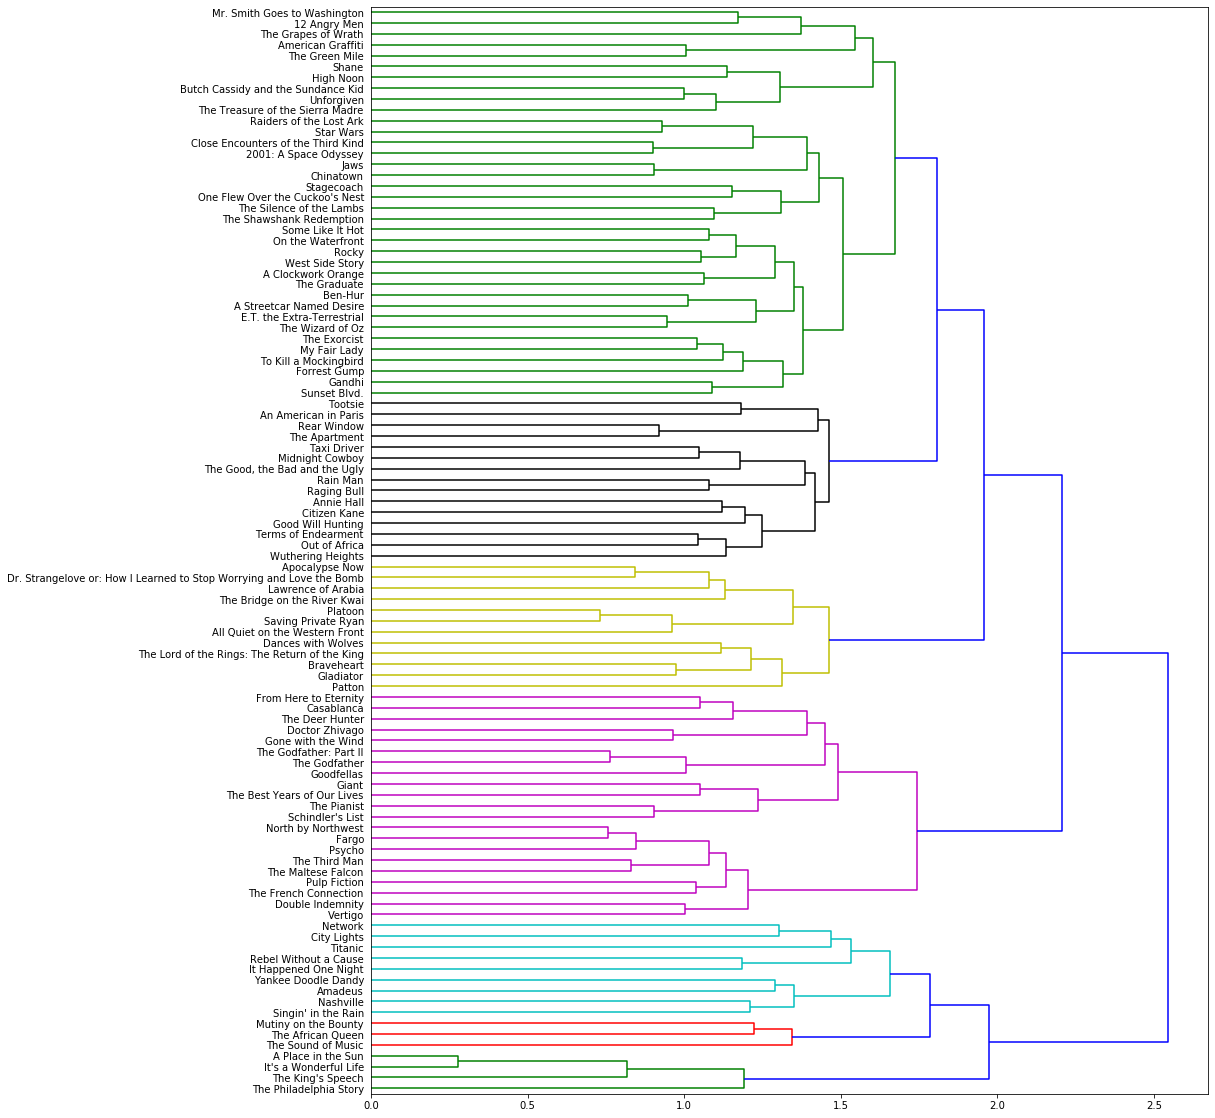

In [27]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import complete, dendrogram

linkage_matrix = complete(dist) # define the linkage_matrix using complete clustering pre-computed distances
                                # can use average(dist) and single(dist) for average and single linkage method. 

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles, leaf_font_size=10);

We can cut the dendrogram at the height that will yield a number of clusters

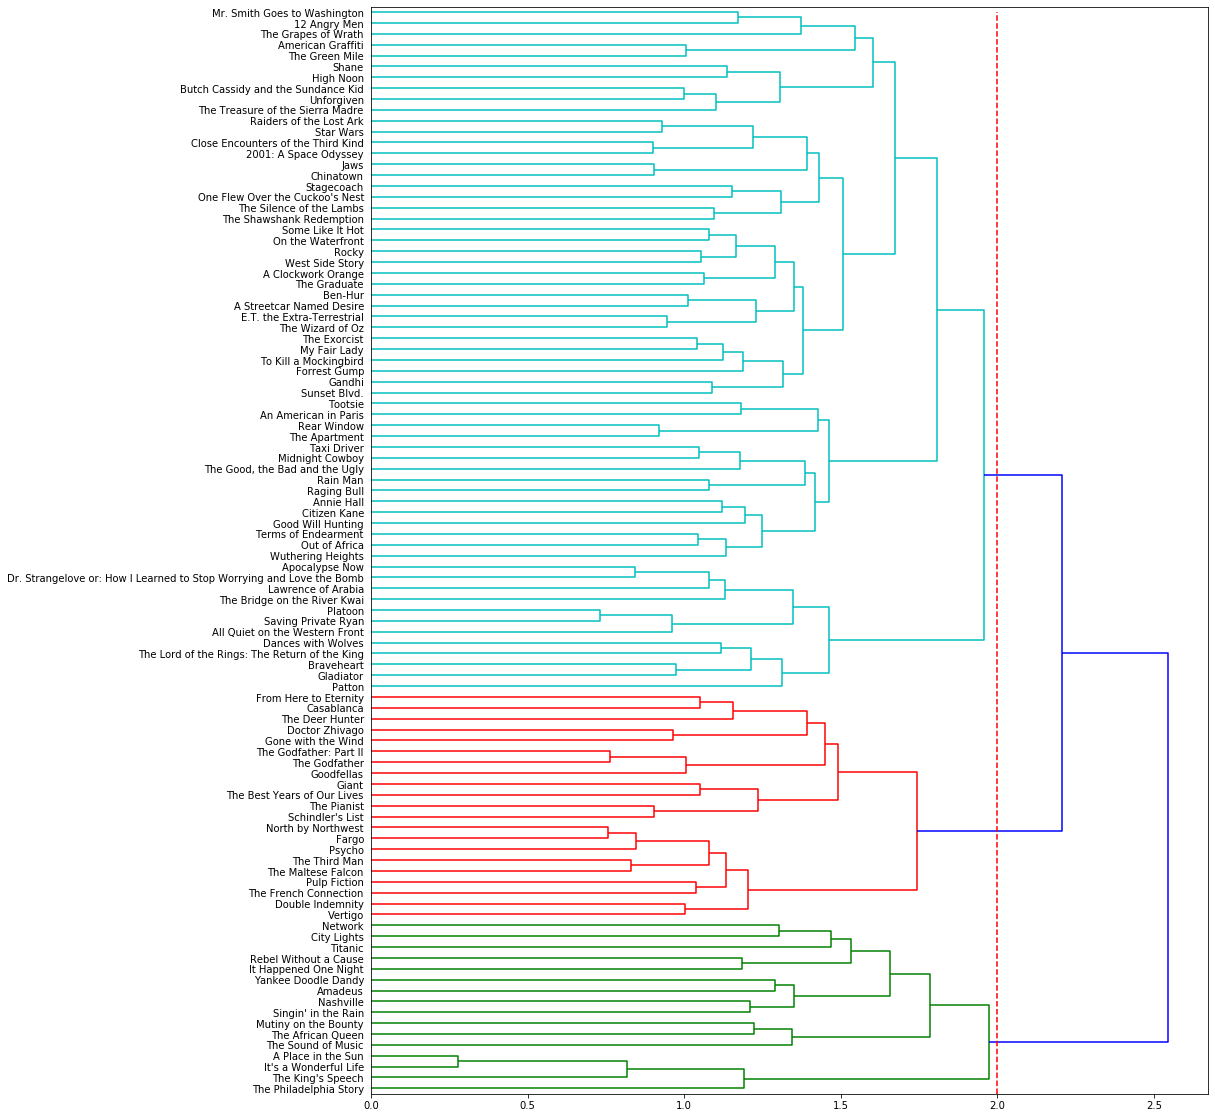

In [28]:
linkage_matrix = complete(dist) # define the linkage_matrix using complete clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles, color_threshold=2, leaf_font_size=10);
# 2 => x axis value
plt.vlines(2,0,plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles='dashed');

Use [average linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.average.html#scipy.cluster.hierarchy.average) method for clustering

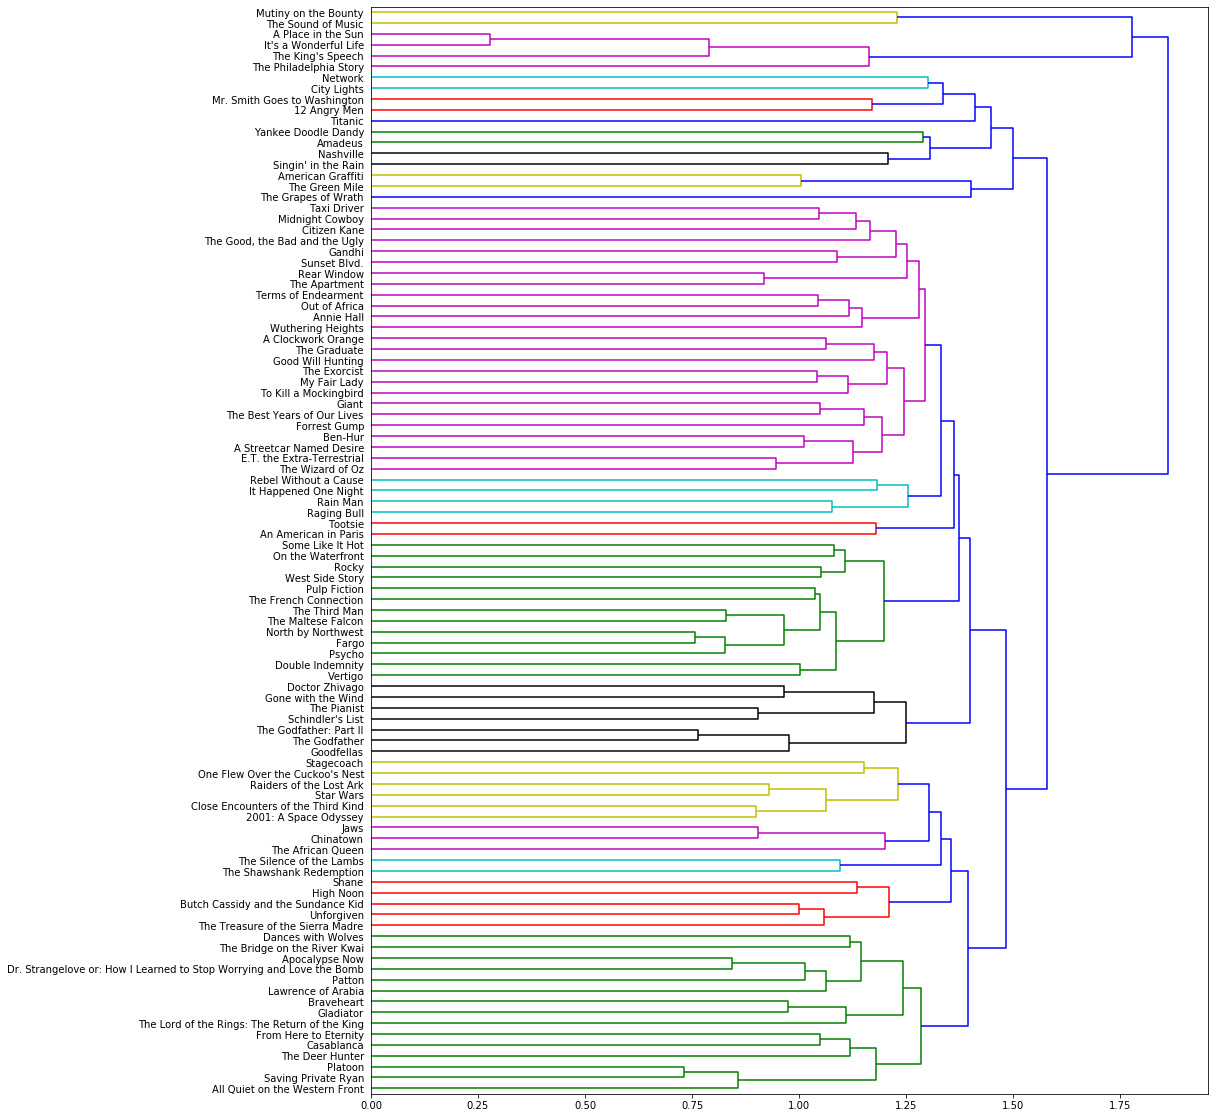

In [29]:
from scipy.cluster.hierarchy import average, dendrogram

linkage_matrix = average(dist) #define the linkage_matrix using average clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles, leaf_font_size=10);

Define the linkage_matrix using complete clustering a collection of m observation vectors in n dimensions (tfidf_matrix). Euclidean distance is used.


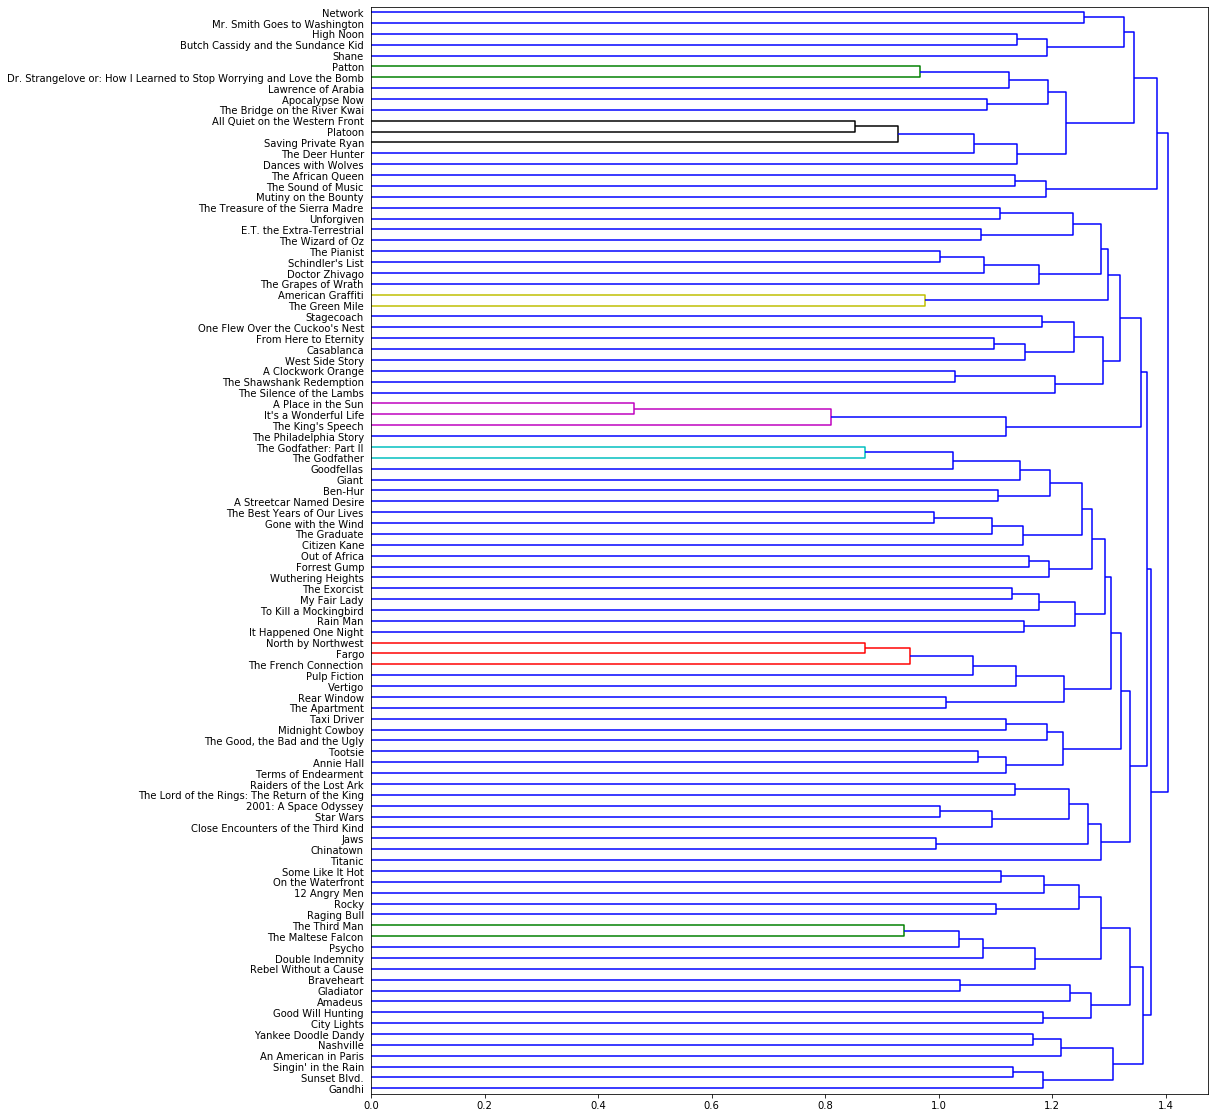

In [30]:
linkage_matrix = complete(tfidf_matrix.toarray()) 

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles, leaf_font_size=10);

In [31]:
plt.close()